# 2019 02 22
## Testing positive feedback signaling circuits
A strain with a rhl negative regulation plasmid and a cin positive regulation plasmid was used to test how signal propagation works with a positive feedback loop. This strain would hopefully act as a low-expresssion constitutive source of LacI such that the low-AHL state is stable. Four pads were constructed and induced with the same AHL pattern/concentration but with different IPTG concentrations. 

In [1]:
import os
import sys
import time
import datetime
import re
import multiprocessing
import ast

import numpy as np
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}

sns.set(rc=rc)

from scipy import ndimage as ndi
import scipy as scp
import pandas as pd

import matplotlib.animation as anm
from IPython.display import HTML

from skimage.external.tifffile import TiffWriter

from PIL import Image

import skimage.filters
import skimage.io
import skimage.morphology
import skimage.feature
import skimage.exposure

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh import palettes, transform

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 24, 
      'xtick.labelsize': 18, 
      'ytick.labelsize': 18, 
      'legend.fontsize': 18,
      'axes.facecolor': 'fbfbfc'}
sns.set_context('talk', rc=rc)

%matplotlib inline
output_notebook()

# you need to populate image lists from the two folders

# file_temp = "/mnt/disks/movie-181208/180827_1/{}/img_{:09d}_{}_000.tif"

Loading BokehJS ...

In [2]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def img_metadata_dict(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        This function uses string replacements to read dictionary key-value pairs.
    
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    return dict(zip(metadata_keys, metadata_vals))

def img_metadata_dict_full(img):
    '''Read metadata into dictionary from the TIFF metadata. 
    
        After some cleanup, this function reads the metadata string directly as a dictionary definition.
    '''
    metadata_key = 50839
    metadata_str = img.tag[metadata_key].decode('utf-8').replace("\x00","")
    in_str = metadata_str[9:].replace('\n','').replace('\s*','').replace('null','None').replace('false','True')
    out_dict = ast.literal_eval(in_str)
    return out_dict

def img_metadata(img):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata = img_metadata_dict(img)
    time_tuple = time.strptime(metadata['Time'],r"%Y-%m-%d %H:%M:%S %z")
    return time.mktime(time_tuple), metadata["Channel"]

def fn_metadata(fn):
    '''Wrapper for reading creation time from an image filename'''
    with Image.open(fn) as img:
        out = img_metadata(img)
    return out

def fn_metadata_full(fn):
    '''Wrapper for reading full metadata dictionary from a filename'''
    with Image.open(fn) as img:
        out = img_metadata_dict_full(img)
    return out

def get_time_vector_from_fn(fn):
    time_dict = dict(zip(channel,len(channel)*[]))
    with Image.open(fn) as img:
        try:
            while 1:
                ct, ch = img_metadata(img)
                time_dict[chan_dict[ch]].append(ct)
                img.seek(img.tell()+1)
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
    return time_dict

def get_data_from_frame(img):
    ct, ch = img_metadata(img)
    im_arr = np.array(list(img.getdata()),dtype=np.uint16).reshape(img.size[::-1])
    return ct, ch, im_arr

def get_movie_from_img(img):
    img_dict = dict(zip(channel,len(channel)*[]))
    time_dict = dict(zip(channel,len(channel)*[]))
    try:
        img.seek(0)
        while 1:
            ct, ch, im_arr = get_data_from_frame(img)
            ch = chan_dict[ch]
            img_dict[ch].append(im_arr)
            time_dict[ch].append(ct)
            img.seek(img.tell()+1)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    for key in img_dict:
        h, w = im_arr.shape
        img_dict[key] = np.vstack([x.reshape((1, h, w, 1)) for x in img_dict[key]])
    return img_dict, time_dict

def read_img(fn):
    with Image.open(fn) as img:
        return get_movie_from_img(img)
        
def concat_img_files(fn_list, fn_out):
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    i = 0
    #ct = datetime.datetime.fromtimestamp(ctime(fn))
    with TiffWriter(fn_out, bigtiff=True) as tif:
        for fn in fn_list:
            eof_flag = True
            print("Writing ", fn)
            with Image.open(fn) as img:
                while eof_flag:
                    _, _, im_arr = get_data_from_frame(img)
                    img_md = img_metadata_dict(img)
                    for k in keep_keys:
                        metadata[k] = img_md[k]
                    metadata['Frame'] = int(os.path.basename(fn).split("_")[1])
                    h, w = im_arr.shape
                    tif.save(im_arr, metadata=metadata.copy())
                    try:
                        i += 1
                        img.seek(img.tell()+1)
                    except:
                        eof_flag = False
        
def convert_img_file(fn, fn_out):
    dirname = os.path.dirname(fn)
    fn_out = os.path.join(dirname, fn_out)
    ct = datetime.datetime.fromtimestamp(ctime(fn))
    eof_flag = True
    with Image.open(fn) as img:
        with TiffWriter(fn_out, bigtiff=True) as tif:
            while eof_flag:
                _, _, im_arr = get_data_from_frame(img)
                metadata = img_metadata_dict(img)
                tif.save(im_arr, datetime=ct, metadata=metadata)
                try:
                    img.seek(img.tell()+1)
                except:
                    eof_flag = False
    
def process_file(fn, skip=0):
    with Image.open(fn) as img:
        eof_flag = True
        column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
        df = pd.DataFrame(columns = column_names)
        try:
            while eof_flag:
                acq_dict = {}
                for i in range(3):
                    ct, ch, im_arr = get_data_from_frame(img)
#                     ch = chan_dict[ch]
                    acq_dict[ch] = (ct, im_arr)
                    try:
                        img.seek(img.tell()+1)
                    except EOFError:
                        eof_flag = False
                rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
                for col_i in range(num):
                    df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                    df = df.append(pd.DataFrame(df_dict), ignore_index=True)
                try:
                    img.seek(img.tell()+3*skip)
                except EOFError:
                    eof_flag = False
        except EOFError:
            pass
        except ValueError:
            pass
        except SyntaxError:
            pass
        df.to_csv(fn+".csv")
    return df

    
def process_file_skimage(fn):
    time_vec = get_time_vector_from_fn(fn)['"Brightfield"']
    im = skimage.io.imread(fn)
    column_names = ('time', 'colony', 'sfcfp', 'mscarlet', 'col_size', 'sfcfp_bg', 'mscarlet_bg')
    df = pd.DataFrame(columns = column_names)
    try:
        while eof_flag:
            acq_dict = {}
            for i in range(3):
                ct, ch, im_arr = get_data_from_frame(img)
                acq_dict[ch] = (ct, im_arr)
                try:
                    img.seek(img.tell()+1)
                except EOFError:
                    eof_flag = False
            rfps, cfps, sizes, num, cfp_bg, rfp_bg = get_fluors(acq_dict['3'][1], acq_dict['5'][1], acq_dict['0'][1])
            for col_i in range(num):
                df_dict = dict(zip(column_names, [[ct], [col_i], [cfps[col_i]], [rfps[col_i]], [sizes[col_i]], [cfp_bg], [rfp_bg]]))
                df = df.append(pd.DataFrame(df_dict), ignore_index=True)
    except EOFError:
        pass
    except ValueError:
        pass
    except SyntaxError:
        pass
    except KeyError:
        pass
    df.to_csv(fn+".csv")
    return df

def ctime(fname):
    '''Read creation time from the TIFF metadata in seconds from Epoch'''
    metadata_key = 50839
    with Image.open(fname) as img:
        metadata_str = img.tag_v2[50839].decode('utf-8').replace("\x00","")
    splits = re.split(",",metadata_str)
    metadata_keys = []
    metadata_vals = []
    for split_x in splits:
        hits = re.findall(r"(?<=\").*?(?=\")", split_x)
        if len(hits) == 3:
            key, _, val = [hit.replace("'","").strip() for hit in hits]
            metadata_keys.append(key)
            metadata_vals.append(val)
    metadata = dict(zip(metadata_keys, metadata_vals))

    time_tuple = time.strptime(metadata['Time'][:-6],r"%Y-%m-%d %H:%M:%S")
    return time.mktime(time_tuple)

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_image(im_arr):
    im_arr = im_arr.astype(np.float32).astype(np.uint16) / 65535
    w, h = im_arr.shape

    # Convert the uneven image to floating point
    im_float = im_arr
    # Smooth to reduce noise
    g_radius = 5
    im_smooth = skimage.filters.gaussian(im_float, g_radius)
    im_bgsub = im_float - im_smooth

    # Perform the median filter
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.exposure.equalize_adapthist(im_adj)

    # Remove small objects and fill holes
    if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
        return np.zeros((w,h)), 1
    thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    selem = skimage.morphology.square(12)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg

def read_tiff_file(fn, skip=0):
    print("Begin " + fn)
    df = process_file(fn, skip=skip)
    df.to_csv(fn+".csv", index=False)
    print("Finished " + fn)

def par_worker(fn_list, skip=1):
    for fn in fn_list:
        read_tiff_file(fn, skip=skip)
    

In [4]:
super_dir = '../20190222_1'
pos_dirs = [os.path.join(super_dir, xx) for xx in os.listdir(super_dir)]
img_files = [os.path.join(pos_dir, xx) for pos_dir in pos_dirs for xx in os.listdir(pos_dir) if '.tif' in xx]
img_re_pattern = '../20190222_1/(?P<pad>[0-9]*)-Pos_(?P<pos>[0-9]*)_000/img_(?P<frame>[0-9]*)_(?P<channel>[0-9]*)_000.tif'


In [5]:
# cor_pos_df

In [50]:
# Extract movie metadata
all_metadata = fn_metadata_full(img_files[0])
summ_dict = all_metadata['Summary']
chan_ind = summ_dict['ChNames']
chan_int = [int(xx) for xx in chan_ind]
n_chan = len(chan_ind)
chan_int_dict = dict(zip(chan_int, np.arange(n_chan)))
chan_name = [all_channel_dict[xx] for xx in chan_ind]
n_pos = summ_dict['Positions']
n_frames = summ_dict['Frames']
im_width = summ_dict['Width']
im_height = summ_dict['Height']

rem = re.findall(img_re_pattern, '\n'.join(img_files), re.MULTILINE)
metadata_arr = np.array(rem).astype(np.int)
n_rows = metadata_arr.shape[0]
pad_vec, pos_vec, frame_vec, channel_vec = metadata_arr.T
padpos_vec = pos_vec // 2
pad_vec = pad_vec - 7
time_vec = np.array([ctime(xx) for xx in img_files])
time_vec = time_vec - time_vec.min()
pos_vec = np.empty(n_rows)

columns = ['pos','padpos','pad','frame','channel','fn','time']
n_rows = len(img_files)
files_df = pd.DataFrame(
    dict(zip(columns, [pos_vec, padpos_vec, pad_vec, frame_vec, channel_vec, img_files, time_vec])))
files_df = files_df.sort_values(by='time')
files_df.loc[:,'pos'] = np.tile(np.repeat(np.arange(n_pos), n_chan), n_frames)

pos_df = files_df.loc[:,['pos','pad','padpos']].groupby('pos').agg(np.min)


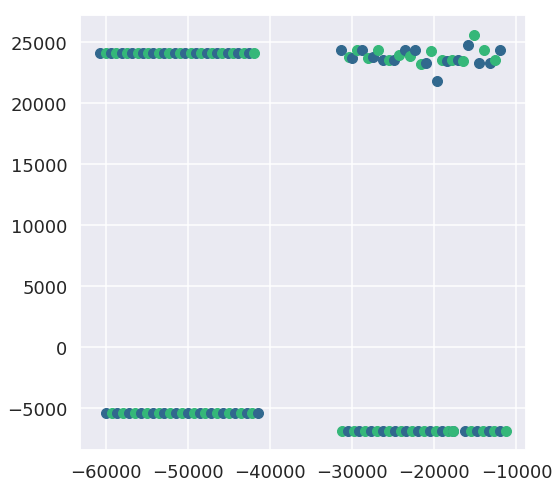

In [51]:

# Cor_pos_df is corrected position DF. In this notebook, correcting the position is not
# necessary as there are only two imaging positions per pad. DF also includes inducer info
# 0, 1, 2 for inducers blank, C, R; respectively
columns = ['x','y','label','padpos', 'pad', 'dist']
n_cols = len(columns)
cor_pos_df = pd.DataFrame(np.empty((n_pos,n_cols)), columns=columns, index=np.arange(n_pos))
for pos in np.arange(n_pos):
    x, y = summ_dict['InitialPositionList'][pos]['DeviceCoordinatesUm']['XYStage']
    label = summ_dict['InitialPositionList'][pos]['Label']
    pad, padpos = pos_df.loc[pos,['pad', 'padpos']]
    cor_pos_df.loc[pos,['x', 'y', 'label', 'pad', 'padpos']] = [x, y, label, pad, padpos]
#     files_df.loc[files_df.pos==p_i,'x'] = x
#     files_df.loc[files_df.pos==p_i,'y'] = y

# cor_pos_df.sort_values(by=['pad','padpos'], inplace=True)
    
for p_i in np.arange(n_pos):
    pad = cor_pos_df.loc[p_i,['pad']].values[0]
    pad_xy = cor_pos_df.loc[(cor_pos_df.pad==pad),['x','y']].iloc[0,:].values
    pos_xy = cor_pos_df.loc[p_i,['x','y']].values
    dist = np.sqrt(np.power(pad_xy - pos_xy,2).sum())
    cor_pos_df.loc[p_i, 'dist'] = dist
    
def dist_f(pad_ind):
    '''
    Calculates distance between colonies for input pad index
    '''
    pos_arr = cor_pos_df.loc[cor_pos_df.pad == 3, ['x', 'y']].values
    dist = np.sqrt(np.sum(np.power(np.diff(pos_arr, axis=0),2)))
    return dist
    
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('viridis', n_colors=2)
    point_color = colors[np.int(np.mod(cor_pos_df.loc[p_i,"pad"],2))]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.label[p_i],
             ms=20,
             c=colors[np.mod(p_i,2)])
# plt.legend()

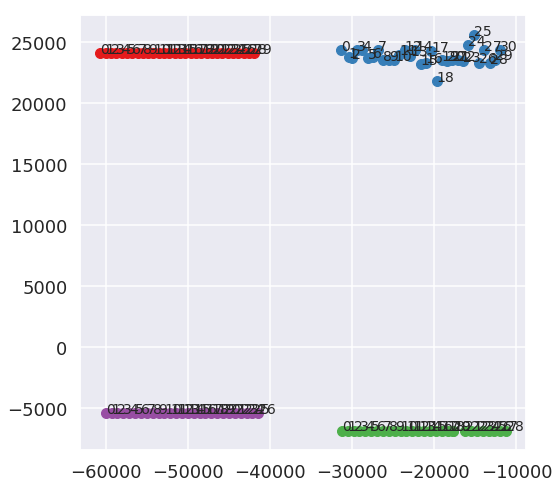

In [52]:
n_pads=4
plt.figure(figsize=(8,8))
for p_i in np.arange(n_pos):
    colors = sns.color_palette('Set1', n_colors=n_pads)
    point_color = colors[np.int(cor_pos_df.loc[p_i,"pad"])]
    plt.plot(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '.', 
             label=cor_pos_df.pad[p_i],
             ms=20,
             c=point_color)
    plt.text(np.float(cor_pos_df.x[p_i]), 
             -np.float(cor_pos_df.y[p_i]), 
             '{}'.format(np.int(cor_pos_df.padpos[p_i])),
             fontsize=14)
# plt.legend()

In [9]:
# sorted_fdf = files_df.sort_values(by=['frame', 'pos', 'channel'])
# print(sorted_fdf)

# quickly just sum all of the fluorescence channels

def par_worker(fdf_sub, fn_out):
    df_index = fdf_sub.index
    n_rows, _ = fdf_sub.shape
    columns = ['pos', 'frame', 'channel', 'sum', 'time']
    n_col = len(columns)
    out_df = pd.DataFrame(np.zeros((n_rows, n_col),dtype=np.int), columns=columns, index=df_index)
    for i in df_index:
        pos, frame, channel, fn, time = fdf_sub.loc[i,['pos', 'frame', 'channel', 'fn', 'time']]
        im = skimage.io.imread(fn)
        img_sum = im.sum().sum()
        out_df.loc[i,:] = np.array([pos, frame, channel, img_sum, time], dtype=np.int)
    out_df.to_csv(fn_out)

fdf_fluor = files_df.loc[files_df.channel > 0,:]
fn_outs = ["worker_outputs/par_output_{}.csv".format(xx) for xx in range(4)]

# jobs = []
# for i in [0,1,2,3]:
#     p = multiprocessing.Process(target=par_worker, 
#                                 args=(fdf_fluor.iloc[i::4,:], fn_outs[i]))
#     jobs.append(p)
#     p.start()
# for j in jobs:
#     j.join()
# print("Done!")


In [58]:
all_data = pd.concat([pd.read_csv(fn, index_col=0) for fn in fn_outs])
sub_chan = len(np.unique(all_data.channel.values))
sub_pos = len(np.unique(all_data.pos.values))
all_data.sort_values(by='time', inplace=True)
pos_to_pad = files_df.loc[:,['pad', 'padpos', 'pos']].groupby('pos').agg(np.min)
meta_cols = pd.concat([cor_pos_df.loc[[xx],['pad','padpos', 'dist']] for xx in all_data.pos.values])
all_data = all_data.assign(pad=meta_cols.pad.values)
all_data = all_data.assign(padpos=meta_cols.padpos.values)
all_data = all_data.assign(dist=meta_cols.dist.values)

In [61]:
all_data.dist.max()

20014.300000000003

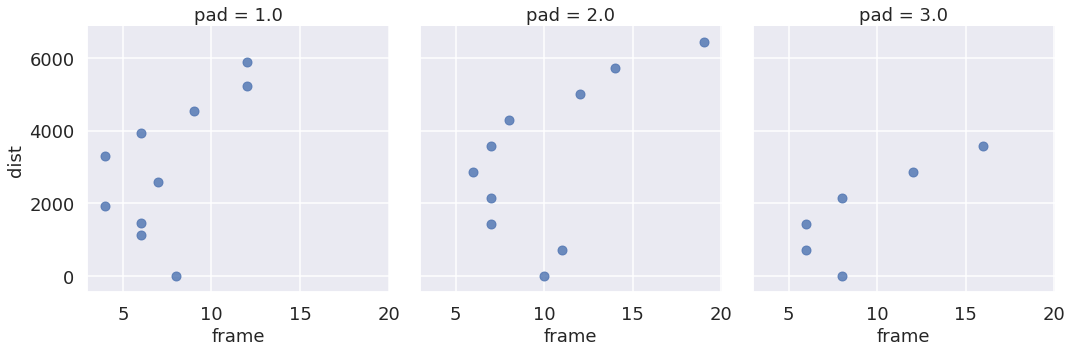

In [63]:
sub_df = all_data.loc[all_data.channel==5,["pos", 'frame', 'sum','pad','padpos','time','dist']]
arr = sub_df.loc[:,['pos','frame','sum']].pivot(values='sum',index='pos',columns='frame').values
thresh = skimage.filters.threshold_yen(arr.astype(np.float))
thresh_df = sub_df.loc[sub_df.loc[:,'sum'] > thresh, ['pos','frame','pad','padpos','time','dist']].groupby('pos').agg(np.min)
# thresh_df
# print(thresh)
# plt.imshow(arr, aspect=1/10)
g = sns.lmplot(data=thresh_df, x='frame', y='dist', fit_reg=False, sharey=True, col='pad')
# g = sns.lmplot(data=sub_df, x='frame', y='sum', hue='padpos', fit_reg=False, sharey=False, col='pad')

In [ ]:
# all_data = pd.concat([pd.read_csv(fn, index_col=0) for fn in fn_outs])
# sub_chan = len(np.unique(all_data.channel.values))
# sub_pos = len(np.unique(all_data.pos.values))
# all_data.sort_values(by='time', inplace=True)
# re-make the frame columns
# all_data.loc[:,'frame'] = np.argsort(all_data.loc[:,'time'])//(sub_chan*sub_pos)

meta_cols = ['x', 'y', 'pad']
index = all_data.index
meta_df = pd.DataFrame(np.empty((all_data.shape[0], len(meta_cols))), index=all_data.index, columns=meta_cols)
for i in cor_pos_df.index:
    pos, x, y, pad = cor_pos_df.loc[i, ['pos', 'x', 'y', 'pad']]
    meta_df.loc[all_data.pos == pos,:] = np.array([x, y, pad])

df = pd.concat([all_data, meta_df], axis=1)
normed_df = df.copy()
bg_pos = df.loc[df.pos==9,:]
for channel in [3,5]:
    for frame_ind in np.arange(n_frames):
        ind = (normed_df.frame==frame_ind)&(normed_df.channel==channel) 
        bg_val = 0#bg_pos.loc[(bg_pos.frame==frame_ind)&(bg_pos.channel==channel),'sum'].values
        normed_df.loc[ind,'sum'] = normed_df.loc[ind,'sum'] - bg_val
g = sns.lmplot(data=df, x='frame', y='sum', row='channel', fit_reg=False, sharey=False, col='pad')
# g.axes[0,0].set_title('RFP Strain 0')
# g.axes[0,1].set_title('RFP Strain 1')
# g.axes[0,2].set_title('RFP Strain 2')
# g.axes[1,0].set_title('CFP Strain 0')
# g.axes[1,1].set_title('CFP Strain 1')
# g.axes[1,2].set_title('CFP Strain 2')

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f644f4732f0> (for post_execute):


ValueError: Image size of 1125720x720 pixels is too large. It must be less than 2^16 in each direction.

In [46]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(df):
    plt.close('all')
    n_frames = df.frame.values.max()
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    channel_dfs = [df.loc[df.channel==3,:], df.loc[df.channel==5,:]]
    vmaxs = [xx['sum'].max() for xx in channel_dfs]
    vmins = [xx['sum'].min() for xx in channel_dfs]
#     vmaxs[0] = 6.25e8
#     vmaxs[1] = 1e9
#     vmins[1] = 6e8
#     bg_dfs = [xx.loc[xx.pos==28, :] for xx in channel_dfs]
    cmaps = ['Reds', 'Greens']
    #     for i in [0,1]:
    #         sub_df = channel_dfs[i]
    #         frame_df = sub_df.loc[sub_df.frame==frame_ind,:]
    #         vmax = vmaxs[i]
    #         vmin = vmins[i]
    #         cmap = cmaps[i]
    #         vec = sub_df['sum'].values
    #         normed = (vec - vmin) / (vmax-vmin)
    #         ax.scatter(sub_df.x, sub_df.y, c=normed, cmap=cmap, alpha=0.5)
    #     ax.set_xticks([])
    #     ax.set_yticks([])


    fig.tight_layout()

    # animation function.  This is called sequentially
    def animate(frame_ind):
        ax.clear()
        for i in [0,1]:
            sub_df = channel_dfs[i]
            frame_df = sub_df.loc[sub_df.frame==frame_ind,:]
#             bg_df = bg_dfs[i]
#             bg_vec = bg_df.loc[bg_df.frame==frame_ind,'sum'].values
            vmax = vmaxs[i]#-bg_df['sum'].max()
            vmin = vmins[i]#-bg_df['sum'].min()
            cmap = cmaps[i]
            color_norm = mpl_colors.Normalize(vmax=vmax, vmin=vmin, clip=True)
            vec = frame_df['sum'].values# - bg_vec
    #         normed = (vec - vmin) / (vmax-vmin)
            ax.scatter(frame_df.x, -frame_df.y, c=vec, cmap=cmap, alpha=0.3, norm=color_norm)
            for indx in frame_df.index:
                x, y, pos = frame_df.loc[indx, ['x', 'y', 'pos']]
                ax.text(x, -y, "{}".format(int(pos)))
        ax.set_xticks([])
        ax.set_yticks([])


    # call the animator.  blit=True means only re-draw the parts that have changed.
#     writer = anm.HTMLWriter()
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=n_frames)


    # Set up formatting for the movie files
#     Writer = anm.writers['pillow']
#     writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(df.loc[df.pad==4,:])
HTML(anim.to_html5_video())

In [10]:
anm.writers.avail

{'pillow': matplotlib.animation.PillowWriter,
 'ffmpeg': matplotlib.animation.FFMpegWriter,
 'ffmpeg_file': matplotlib.animation.FFMpegFileWriter,
 'imagemagick': matplotlib.animation.ImageMagickWriter,
 'imagemagick_file': matplotlib.animation.ImageMagickFileWriter,
 'html': matplotlib.animation.HTMLWriter}

In [ ]:
# Make a tiff image stack with a mask channel
def make_movie(fn_out, t_skip=10, p_skip=1, n_pos=n_pos,n_frames=n_frames):
    # I don't think this works but keep a metadata dictionary to store useful metatdata in 
    # the output video
    keep_keys = ['Channel', 'Time', 'PositionName']
    metadata = dict(zip(keep_keys, keep_keys))
    # Set indices
    i = 0
    t_points = np.arange(0,n_frames,t_skip)
    t_len = len(t_points)
    p_points = np.arange(0,n_pos,p_skip)
    p_len = len(p_points)
    im_out = np.zeros((t_len,p_len,n_chan+1,im_height,im_width,1), dtype=np.uint16)
    # Write movie to file
    with TiffWriter(fn_out, imagej=True, append=False) as tif:
        for tp in t_points:
            for pp in p_points:
                # position label is used to complete filename
                # strain is used to determine which fluorescence channel to use for segmentation
                pos_str, strain = cor_pos_df.loc[pp, ['label', 'strain']]
                if strain == 'pCR':
                    segment_channel = 1 # gfp channel
                else:
                    segment_channel = 2 # rfp channel
                for cp in chan_int:
                    pos_str = cor_pos_df.loc[pp, 'label']
                    fn = file_temp.format(pos_str, tp, cp)
                    eof_flag = True
                    print("Writing ", fn)
                    with Image.open(fn) as img:
                        while eof_flag:
                            # Get image array
                            _, _, im_arr = get_data_from_frame(img)
                            # Label image
                            if cp == segment_channel:
                                im_lab, col_num = label_image(im_arr)
                                im_out[tp//t_skip, pp//p_skip, n_chan, :, :, 0] = im_lab.astype(np.uint16)
                            # Downscale if image width is more than 2000 pixels
                            if im_arr.shape[0] > 2000:
                                im_arr = np.round(skimage.transform.downscale_local_mean(im_arr, (2,2)))
                            im_arr = im_arr.astype(np.float32).astype(np.uint16)
                            # I'm not sure this works but keep image metadata for the current frame
                            img_md = img_metadata_dict_full(img)
                            for k in keep_keys:
                                metadata[k] = img_md[k]
                            h, w = im_arr.shape
                            im_out[tp//t_skip, pp//p_skip, chan_int_dict[cp], :, :, 0] = im_arr
                            try:
                                i += 1
                                img.seek(img.tell()+1)
                            except:
                                eof_flag = False
        tif.save(im_out, metadata=metadata.copy())

# make_movie('fullmovie_mask.tif', n_frames=80, n_pos=6)

In [ ]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(df, skip=10, pad=3):
    plt.close('all')
    pad_df = df.loc[df.pad==pad,:]
    xlims = [df['x'].min(), df['x'].min()]
    xlims = [df['x'].min(), df['x'].min()]
    t_points, s, c, h, w = img.shape
    t_vec = np.arange(0, t_points, skip)
    frames = len(t_vec)
    #t_list = list(t_vec[-1::-1]) + [-1]
    
    t_list = np.arange(t_points)
    
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,2, figsize=(10,8))
    im_list = [0,0,0,0]
    
    # initialize plots
    titles = ['bf', 'gfp', 'mscarlet', 'lab']
    vmaxs = [2.8e4  , 1e4, 1e4, 1]
    vmins = [1e4, 1e3, 1e3, 0]
    for i in np.arange(3):
        ax = axs[i//2, np.mod(i,2)]
        indxs = [i]
        vmax = vmaxs[i]
        vmin = vmins[i]
        im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none')
        cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i])
        im_list[i] = im
    
    fig.tight_layout()
    
    # animation function.  This is called sequentially
    frame_arr = np.zeros((h,w))
    def animate(i):
        # Plot 
        for j in np.arange(3):
            ax = axs[j//2, np.mod(j,2)]
            frame_arr = img[i*skip,pos,j,:,:]#.sum(axis=0)
            im_list[j].set_array(frame_arr)

    # call the animator.  blit=True means only re-draw the parts that have changed.
#     writer = anm.HTMLWriter()
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, skip=1, pos=7)
HTML(anim.to_jshtml())

In [11]:
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(im_arr, scale=10, pad_ind=3):
    
    n_frames, n_pos, h, w, n_chan = im_arr.shape
    plt.close('all')
    pixels_per_um = h/700.0
    pad_df = df.loc[df.pad==pad_ind,:]
    pos_list = np.unique(pad_df.pos.values)
    xlims = np.array([pad_df.x.min()-800, pad_df.x.max()+800])*pixels_per_um
    ylims = np.array([pad_df.y.min()-800, pad_df.y.max()+800])*pixels_per_um
    rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
    pad_w = np.int(np.ceil(np.diff(xlims)))
    pad_h = np.int(np.ceil(np.diff(ylims)))
    pad_arr = np.zeros((pad_h, pad_w, 3))
    rfp_norm = mpl_colors.Normalize(550, 800,clip=True)
    cfp_norm = mpl_colors.Normalize(1e3, 2e3,clip=True)
    pos_lims = (pad_df[['pos','x','y']].groupby('pos').agg(np.min)*pixels_per_um).astype(np.int)
    def get_frame_arr(frame_ind):
        for pos in pos_list:
            x0, y0 = pos_lims.loc[pos,:].values - rel_mins[:,0]//1
        #     img_arr[y0:y0+1024,x0:x0+1024] = 1
#             rfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==3),'fn'].values[0]
#             cfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==5),'fn'].values[0]
            rfp_arr = im_all[frame_ind, pos, :,:,1]#skimage.filters.gaussian(skimage.io.imread(rfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
            cfp_arr = im_all[frame_ind, pos, :,:,2]#skimage.filters.gaussian(skimage.io.imread(cfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
            arr_rgb = np.zeros((w, h, 3))
            arr_rgb[:,:,0] = rfp_norm(rfp_arr)
            arr_rgb[:,:,1] = 0.75*cfp_norm(cfp_arr)
            arr_rgb[:,:,2] = 0.75*cfp_norm(cfp_arr)
            pad_arr[y0:y0+h,x0:x0+w] = arr_rgb
#         return img_arr
    
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    im = ax.imshow(skimage.transform.downscale_local_mean(pad_arr,(scale,scale,1)), animated=True, interpolation='none')
#     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Pad {}".format(pad_ind))

    fig.tight_layout()
    
    def animate(i):
        # Plot 
        get_frame_arr(i)
        im.set_array(skimage.transform.downscale_local_mean(pad_arr,(scale,scale,1)))
        
    # call the animator.  blit=True means only re-draw the parts that have changed.
#     writer = anm.HTMLWriter()
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=n_frames)


    # Set up formatting for the movie files
    #Writer = anm.writers['ffmpeg_file']
    #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=900, extra_args=['-vcodec', 'libx264'])

    # save the animation as an mp4.  This requires ffmpeg or mencoder to be
    # installed.  The extra_args ensure that the x264 codec is used, so that
    # the video can be embedded in html5.  You may need to adjust this for
    # your system: for more information, see
    # http://matplotlib.sourceforge.net/api/animation_api.html
    #anim.save('animation_{}.mp4'.format(fn), extra_args=['-vcodec', 'libx264'], dpi=50, writer=writer)
    #plt.close('all')


    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim = write_movie(im_all, scale=8, pad_ind=5)
anim.save('190110_pad5.gif', dpi=80, fps=15, writer='pillow')
anim = write_movie(im_all, scale=8, pad_ind=4)
anim.save('190110_pad4.gif', dpi=80, fps=15, writer='pillow')

In [ ]:
pixels_per_um = 1024/700.0
pad_ind = 3
frame_ind = 10
pad_df = df.loc[df.pad==pad_ind,:]
pos_list = np.unique(pad_df.pos.values)
xlims = np.array([pad_df.x.min()-400, pad_df.x.max()+800])*pixels_per_um
ylims = np.array([pad_df.y.min()-400, pad_df.y.max()+800])*pixels_per_um
rel_mins = np.concatenate([[xlims], [ylims]],axis=0).astype(np.int)
img_w = np.int(np.ceil(np.diff(xlims)))
img_h = np.int(np.ceil(np.diff(ylims)))
img_arr = np.zeros((img_h, img_w, 3))
pos_lims = (pad_df[['pos','x','y']].groupby('pos').agg(np.min)*pixels_per_um).astype(np.int)
for pos in pos_list:
    x0, y0 = pos_lims.loc[pos,:].values - rel_mins[:,0]//1
#     img_arr[y0:y0+1024,x0:x0+1024] = 1
    rfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==3),'fn'].values[0]
    cfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==5),'fn'].values[0]
    rfp_arr = skimage.filters.gaussian(skimage.io.imread(rfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
    cfp_arr = skimage.filters.gaussian(skimage.io.imread(cfp_fn).astype(np.float),1)#skimage.morphology.disk(4))
    rfp_norm = mpl_colors.Normalize(550, 800,clip=True)
    cfp_norm = mpl_colors.Normalize(1e3, 2e3,clip=True)
    arr_rgb = np.zeros((1024, 1024, 3))
    arr_rgb[:,:,0] = rfp_norm(rfp_arr)
    arr_rgb[:,:,1] = 0.75*cfp_norm(cfp_arr)
    arr_rgb[:,:,2] = 0.75*cfp_norm(cfp_arr)
    img_arr[y0:y0+1024,x0:x0+1024] = arr_rgb

    
# for pos_ind in pos_list:
#     pos_lims.loc[pos_ind,:] = np.int(pad_df[])
    
plt.imshow(img_arr[::4,::4,:])
plt.xticks([])
plt.yticks([])

In [ ]:
frame_ind = 30
rfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==3),'fn']
cfp_fn = files_df.loc[(files_df.frame==frame_ind)&(files_df.pos==pos)&(files_df.channel==5),'fn']
rfp_arr = skimage.filters.median(skimage.io.imread(rfp_fn.values[0]),skimage.morphology.disk(4))
cfp_arr = skimage.filters.median(skimage.io.imread(cfp_fn.values[0]),skimage.morphology.disk(4))
rfp_norm = mpl_colors.Normalize(rfp_arr.min(), rfp_arr.max(),clip=True)
cfp_norm = mpl_colors.Normalize(cfp_arr.min(), cfp_arr.max(),clip=True)
arr_rgb = np.zeros((1024, 1024, 3))
arr_rgb[:,:,0] = rfp_norm(rfp_arr)
arr_rgb[:,:,1] = 0.75*cfp_norm(cfp_arr)
arr_rgb[:,:,2] = 0.75*cfp_norm(cfp_arr)
plt.imshow(arr_rgb)


In [ ]:

rfp_norm = mpl_colors.Normalize(rfp_arr.min(), rfp_arr.max(),clip=True)
cfp_norm = mpl_colors.Normalize(cfp_arr.min(), cfp_arr.max(),clip=True)
cyan = np.array([xx*np.ones((1024,1024)) for xx in mpl_colors.BASE_COLORS['c']])
cyan.shape
# red = np.array([[mpl_colors.BASE_COLORS['r']]])

# plt.imshow(cyan*cfp_norm(cfp_arr) + red*rfp_norm(rfp_arr))

In [10]:
im_all = skimage.io.imread('../20190110_both_pulsers_1/downsampled.tif')

In [ ]:
im_all.shape

In [ ]:
# Channel information for IX81 inverted microscope
all_channel_inds = [str(xx) for xx in range(6)]
all_channel_names = ['Brightfield', 'GFP', 'YFP', 'mScarlet', 'unk', 'sfCFP']
all_channel_dict = dict(zip(all_channel_inds, all_channel_names))

def crop(img):
    w, h = img.shape
    if w > 1000:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    return(img[y1:y2,x1:x2])

def uncrop(img):
    w, h = img.shape
    if w > 800:
        out_img = np.zeros((512*2, 672*2))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))*2
    else:
        out_img = np.zeros((512, 672))
        x1, x2, y1, y2 = np.array((80, 650 ,20, 550))
    out_img[y1:y2,x1:x2] = img
    return(out_img)

def label_fluor_im(im_arr, thresh_min=200):
    im_arr = im_arr.astype(np.float32).astype(np.uint16)# / 65535
    w, h = im_arr.shape

    # Smooth to reduce large-scale artifacts
#     selem = skimage.morphology.square(120)
    im_smooth = skimage.filters.gaussian(im_arr, 200).astype(np.uint16)
    im_bgsub = im_arr - im_smooth
    selem = skimage.morphology.square(4)
    im_bgsub = skimage.filters.median(im_bgsub, selem)

    # Perform the median filter
#     selem = skimage.morphology.square(2)
#     im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0
    
    # Threshold
    thresh = skimage.filters.threshold_li(im_bgsub)
    thresh = np.max([thresh, thresh_min])
    print(thresh)
#     im_thresh = im_bgsub > thresh
    # Remove small objects and fill holes
#     if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
#         return np.zeros((w,h)), 1
#     thresh = skimage.filters.threshold_otsu(im_edge)
    selem = skimage.morphology.square(2)
    im_bw = skimage.morphology.binary_dilation(im_bgsub > thresh, selem)
    selem = skimage.morphology.square(6)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=10)
    
    im_labeled, num = skimage.morphology.label(im_bw, return_num=True)
    return im_labeled, num

def get_fluors(bfi, rfp, gfp):
    im_labeled, num = label_image_2(bfi)
    num  = im_labeled.max()
#     rfp, gfp = [crop(x) for x in [rfp, gfp]]
    gfps = [np.mean(gfp[im_labeled == x]) for x in np.arange(1,num+1)]
    rfps = [np.mean(rfp[im_labeled == x]) for x in np.arange(1,num+1)]
    gfp_bg = np.mean(gfp[im_labeled == 0])
    rfp_bg = np.mean(rfp[im_labeled == 0])
    sizes = [np.sum(im_labeled == x) for x in np.arange(1,num+1)]
    return rfps, gfps, sizes, num, gfp_bg, rfp_bg


In [ ]:
rfp_norm = mpl_colors.Normalize(550, 800,clip=True)
cfp_norm = mpl_colors.Normalize(1e3, 2e3,clip=True)
frame, pos, channel = 45, 45, 1
im = im_all[frame,pos,:,:,channel]
im_lab, num = label_fluor_im(im,0)
plt.imshow(im_lab>0)
plt.figure()
plt.imshow(rfp_norm(im))
plt.figure()
plt.imshow(im>6e3)

In [36]:
frame, pos, chan = 1, 11, 1
pos10_fns = files_df.loc[files_df.pos==10,['frame','channel','fn']].pivot(columns='channel',index='frame',values='fn')

def mask_fluor(im_arr, im_bg):
    im_smooth = skimage.filters.gaussian(im_arr, 4)#, preserve_range=True)
    im_bg = skimage.filters.gaussian(im_bg, 100)#, preserve_range=True)
    im_bgsub=im_smooth - im_bg
    

    # Adjust exposure
    im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

    # Edge detection
    im_edge = skimage.filters.sobel(im_adj)
    im_edge = skimage.filters.gaussian(im_edge, 2)
    im_edge[np.isnan(im_edge)] = 0
    if np.diff([xx_fn(im_edge) for xx_fn in [np.min, np.max]]) <= 0:
        im_bw = np.zeros(im_arr.shape, dtype=np.uint8)
        return im_bw.astype(np.uint8)
        

    # Threshold
    selem = skimage.morphology.square(2)
    thresh = skimage.filters.threshold_otsu(im_edge)
    im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
    im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=50)
    selem = skimage.morphology.square(10)
    im_bw = skimage.morphology.binary_closing(im_bw, selem)
    dif_test = np.mean(im_smooth[im_bw] - im_bg[im_bw])
    if dif_test < 1e-4:
        im_bw = np.zeros(im_arr.shape, dtype=np.uint8)
        return im_bw.astype(np.uint8)
    
    return im_bw.astype(np.uint8)

output_template = "worker_outputs/mask_f{:02d}_p{:02d}_c{:02d}.tif"
def par_worker(fdf, pos10_fns=pos10_fns):
    for indx in fdf.index:
        pos, pad, frame, channel, fn = fdf.loc[indx,['pos','pad','frame','channel','fn']]
        output_fn = output_template.format(frame, pos, channel)
        if output_fn in os.listdir('worker_outputs/'):
            continue
        im_arr = skimage.io.imread(fn)
        im_bg = skimage.io.imread(pos10_fns.loc[frame,channel])
        im_bw = mask_fluor(im_arr, im_bg)
        skimage.io.imsave(arr=im_bw, fname=output_fn)

def par_worker_test(fdf, pos10_fns=pos10_fns):
    for indx in fdf.index:
        pos, pad, frame, channel, fn = fdf.loc[indx,['pos','pad','frame','channel','fn']]
        im_arr = skimage.io.imread(fn)
        im_bg = skimage.io.imread(pos10_fns.loc[frame,channel])
        output_fn = output_template.format(frame, pos, channel)
        im_bw = mask_fluor(im_arr, im_bg)
        fig, axs = plt.subplots(1,3)
        axs[0].imshow(im_arr)
        axs[1].imshow(im_bg)
        axs[2].imshow(im_bw)
#         skimage.io.imsave(arr=im_bw, fname=output_fn)
# inc_ind = 0
# par_worker_test(fdf_fluor.loc[[1375],:])
# inc_ind += 1
# par_worker_test(fdf_fluor.loc[[2873],:])

In [ ]:
fdf.loc[(fdf.frame==45)&(fdf.pos==4)&(fdf.channel==5),:]

In [37]:
fdf = fdf_fluor.loc[(np.mod(fdf_fluor.frame,5) != 0)&(fdf_fluor.pos != 10),:]
jobs = []
for i in [0,1,2,3]:
    p = multiprocessing.Process(target=par_worker, 
                                args=(fdf.iloc[i::4,:], pos10_fns.copy()))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")


/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p25_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p25_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p25_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p25_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p25_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p25_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p25_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p25_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p25_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p40_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p40_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p40_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p40_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p40_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p40_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p40_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p40_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p40_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p40_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p08_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p08_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p08_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p08_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p08_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p08_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p08_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p08_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p08_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p35_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p35_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p35_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p35_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p35_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p35_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p35_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p35_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p24_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p24_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p35_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p24_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p24_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p24_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p24_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p24_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p24_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p24_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p30_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p30_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p30_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p30_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p30_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p30_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p30_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p30_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p30_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p30_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p23_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p23_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p23_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p23_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p23_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p23_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p23_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p23_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p56_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p56_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p56_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p56_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p56_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p56_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p56_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p56_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p56_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p56_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p01_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p01_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p01_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p01_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p04_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p04_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p04_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p04_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p04_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p04_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p04_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p04_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p04_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p04_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p04_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p13_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p13_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p13_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p13_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p13_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p13_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p13_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p20_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p13_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p20_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p20_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p20_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p20_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p20_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p20_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p20_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p26_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p26_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p26_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p26_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p26_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p26_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p26_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p26_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p26_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p26_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p19_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p19_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p19_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p19_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p37_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p37_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p37_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p37_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p37_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p37_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p37_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p21_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p21_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p21_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p21_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p49_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p49_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p49_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p49_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p49_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p49_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p49_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p49_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p49_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p49_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p49_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p46_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p46_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p46_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p46_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p46_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p46_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p46_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p05_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p05_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p05_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p05_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p05_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p31_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p31_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p31_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p31_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p31_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p31_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p31_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p31_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p31_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p31_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p03_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p03_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p03_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p03_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p03_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p16_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p16_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p16_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p16_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p16_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p16_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p16_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p16_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p38_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p38_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p38_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p38_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p38_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p38_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p38_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p38_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p38_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p07_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p07_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p07_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p07_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p07_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p07_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p07_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p07_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p17_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p17_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p17_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p17_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p12_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p12_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p12_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p12_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p12_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p12_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p12_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p42_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p42_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p42_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p42_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p33_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p33_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p33_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p33_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p33_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p33_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p33_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p33_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p00_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p00_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p00_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p00_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p00_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p00_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p00_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p00_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p14_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p00_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p14_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p14_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p14_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p14_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p14_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p14_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p14_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p14_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p14_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p28_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p28_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p28_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p28_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p28_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p28_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p28_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p28_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p28_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p28_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p29_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p29_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p29_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p29_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p29_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p29_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p29_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p54_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p54_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p54_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p54_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p54_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p54_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p54_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p54_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p54_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p44_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p44_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p44_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p44_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p44_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p44_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p44_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p47_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p47_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p47_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p47_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p47_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p47_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p47_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p47_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p47_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p06_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p06_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p06_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p06_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p06_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p06_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p06_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p06_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p52_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p06_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p52_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p52_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p52_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p52_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p52_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p52_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p52_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p52_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p50_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p50_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p50_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p50_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p50_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p50_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p50_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p50_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p50_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p27_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p27_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p27_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p27_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p27_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p27_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p27_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p27_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p27_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p39_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p39_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p39_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p39_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p39_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p39_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p39_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p39_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p09_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p09_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p09_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p09_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p09_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p09_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p09_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p22_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p22_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p22_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p22_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p22_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p18_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p18_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p18_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p41_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p41_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p41_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p41_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p41_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p41_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p41_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p41_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p43_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p43_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p43_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p43_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p43_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p43_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p43_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p43_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p43_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p43_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p53_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p53_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p53_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p53_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p53_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p53_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p53_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p53_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p32_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p53_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p32_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p32_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p32_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p32_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p32_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p32_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p32_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p32_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p32_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p11_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f23_p11_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p11_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p11_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p11_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p11_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p11_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p11_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p11_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p34_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p34_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f17_p34_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f31_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p34_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p48_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p48_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f01_p48_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p48_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p48_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p48_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p48_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p48_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p48_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p48_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f34_p36_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p36_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p36_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p36_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f36_p36_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p36_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p36_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p51_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p51_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p51_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f37_p51_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p51_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p51_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f02_p51_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f38_p51_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p51_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f41_p51_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f11_p51_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p45_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p45_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f24_p45_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f14_p45_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f27_p45_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p45_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f26_p45_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f43_p45_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f39_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f32_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p55_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f33_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p55_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f48_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f19_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f12_p55_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f08_p55_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f49_p15_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f47_p55_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f22_p15_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f28_p15_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f16_p15_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f09_p15_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f18_p15_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f29_p15_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p15_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f04_p02_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f44_p02_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f46_p02_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f13_p02_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f07_p02_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f03_p02_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f06_p02_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/p

/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f21_p02_c03.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/skimage/io/_io.py:140: UserWarning: worker_outputs/mask_f42_p02_c05.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/opt/anaconda/miniconda3/lib/p

Done!


In [ ]:
frame, pos, chan = 15, 0, 1
thresh_min = 1
im_arr = im_all[frame,pos,:,:,chan].copy()
# selem = skimage.morphology.square(4)
im_smooth = skimage.filters.gaussian(im_arr, 4) / 65535
pos_10 = skimage.filters.gaussian(im_all[frame,pos,:,:,chan],100,preserve_range=True)/65535 
im_bg = skimage.filters.gaussian(im_all[frame,pos,:,:,chan],100,preserve_range=True)/65535
im_bgsub = im_smooth - im_bg

# plt.imshow((im_arr-im_bg) > 20)

# Perform the median filter
#     selem = skimage.morphology.square(2)
#     im_bgsub = skimage.filters.median(im_bgsub, selem) / 4096.0

# Adjust exposure
im_adj = skimage.exposure.equalize_adapthist(im_bgsub)

# Edge detection
im_edge = skimage.filters.sobel(im_adj)
# im_edge = skimage.exposure.equalize_adapthist(im_edge)

# thresh = np.max([thresh, thresh_min])
#     im_thresh = im_bgsub > thresh
# Remove small objects and fill holes
#     if np.all(im_edge == im_edge[0,0]) or np.any(np.isnan(im_edge)):
#         return np.zeros((w,h)), 1
#     thresh = skimage.filters.threshold_otsu(im_edge)
# selem = skimage.morphology.square(2)
im_edge = skimage.filters.gaussian(im_edge, 2)

# Threshold
thresh = skimage.filters.threshold_otsu(im_edge)
im_bw = skimage.morphology.binary_dilation(im_edge > thresh, selem)
selem = skimage.morphology.square(3)
im_bw = skimage.morphology.binary_closing(im_bw, selem)

im_bw = skimage.morphology.remove_small_objects(im_bw, min_size=20)

plt.figure()
plt.imshow(im_arr)
plt.figure()
plt.imshow(im_bg)
plt.figure()
plt.imshow(im_smooth)
plt.figure()
plt.imshow(im_bgsub)
plt.figure()
plt.imshow(im_edge)
plt.figure()
plt.imshow(im_edge>thresh)
plt.figure()
plt.imshow(im_bw)
plt.figure()
im_labeled, num = skimage.morphology.label(im_bw, return_num=True)

In [ ]:
fdf_fluor.loc[fdf_fluor.pos==11,:]

In [ ]:
mask_files = [os.path.join('worker_outputs',xx) for xx in os.listdir('worker_outputs/') if '.tif' in xx]
# fn = mask_files[0]
# print(fn)
# im = skimage.io.imread(fn)
# plt.imshow(im)
len(mask_files)

In [ ]:
pos_list, frame_list, channel_list = [np.unique(fdf[xx].values) for xx in ['pos', 'frame', 'channel']]
n_pos, n_frame, n_channel = [len(xx) for xx in [pos_list, frame_list, channel_list]]
pos_to_ind = dict(zip(pos_list, range(n_pos)))
frame_to_ind = dict(zip(frame_list, range(n_frame)))
channel_to_ind = dict(zip(channel_list, range(n_channel)))
mask_arr = np.zeros((n_frame, n_pos, 1024, 1024, n_channel))
for indx in fdf.index:
    pos, pad, frame, channel, fn = fdf.loc[indx,['pos','pad','frame','channel','fn']]
    im_arr = skimage.io.imread(fn)
    im_bg = skimage.io.imread(pos10_fns.loc[frame,channel])
    mask_fn = output_template.format(frame, pos, channel)
    im_mask = skimage.io.imread(mask_fn)
    mask_arr[frame_to_ind[frame], pos_to_ind[pos], :, :, channel_to_ind[channel]] = im_mask

In [18]:
pos10_fns = files_df.loc[files_df.pos==10,['frame','channel','fn']].pivot(columns='channel',index='frame',values='fn')
columns = ['pos','frame','channel','mask_fluor','mask_size','mean_fluor']
output_template = "worker_outputs/mask_f{:02d}_p{:02d}_c{:02d}.tif"
def par_worker(fdf, pos10_fns, out_csv):
    masked_fluor_df = pd.DataFrame(np.zeros((fdf.shape[0], len(columns))),
                               columns=columns,
                               index=fdf.index)
    for indx in fdf.index:
        pos, pad, frame, channel, fn = fdf.loc[indx,['pos','pad','frame','channel','fn']]
        output_fn = output_template.format(frame, pos, channel)
        im_arr = skimage.io.imread(fn)
        im_bg = skimage.io.imread(pos10_fns.loc[frame,channel])
        mask_fn = output_template.format(frame, pos, channel)
        im_mask = skimage.io.imread(mask_fn)
        im_masked = (im_arr - skimage.filters.gaussian(im_bg, 100, preserve_range=True)) * (im_mask > 0)
        mask_fluor = im_masked.sum()
        mask_size = im_mask.sum()
        if mask_size == 0 :
            mean_fluor = 0
        else:
            mean_fluor = mask_fluor / mask_size
        masked_fluor_df.loc[indx,:] = np.array([pos, frame, channel, mask_fluor, mask_size, mean_fluor])
    masked_fluor_df.to_csv(out_csv)
    #     mask_arr[frame_to_ind[frame], pos_to_ind[pos], :, :, channel_to_ind[channel]] = im_mask

fdf = fdf_fluor.loc[(np.mod(fdf_fluor.frame,5) == 0)&(fdf_fluor.pos != 10),:]
csv_out_tmp = "worker_outputs/mask_part_again{}.csv"

jobs = []
for i in [0,1,2,3]:
    out_fn = csv_out_tmp.format(i)
    p = multiprocessing.Process(target=par_worker, 
                                args=(fdf.iloc[i::4,:], pos10_fns.copy(),out_fn))
    jobs.append(p)
    p.start()
for j in jobs:
    j.join()
print("Done!")


Done!


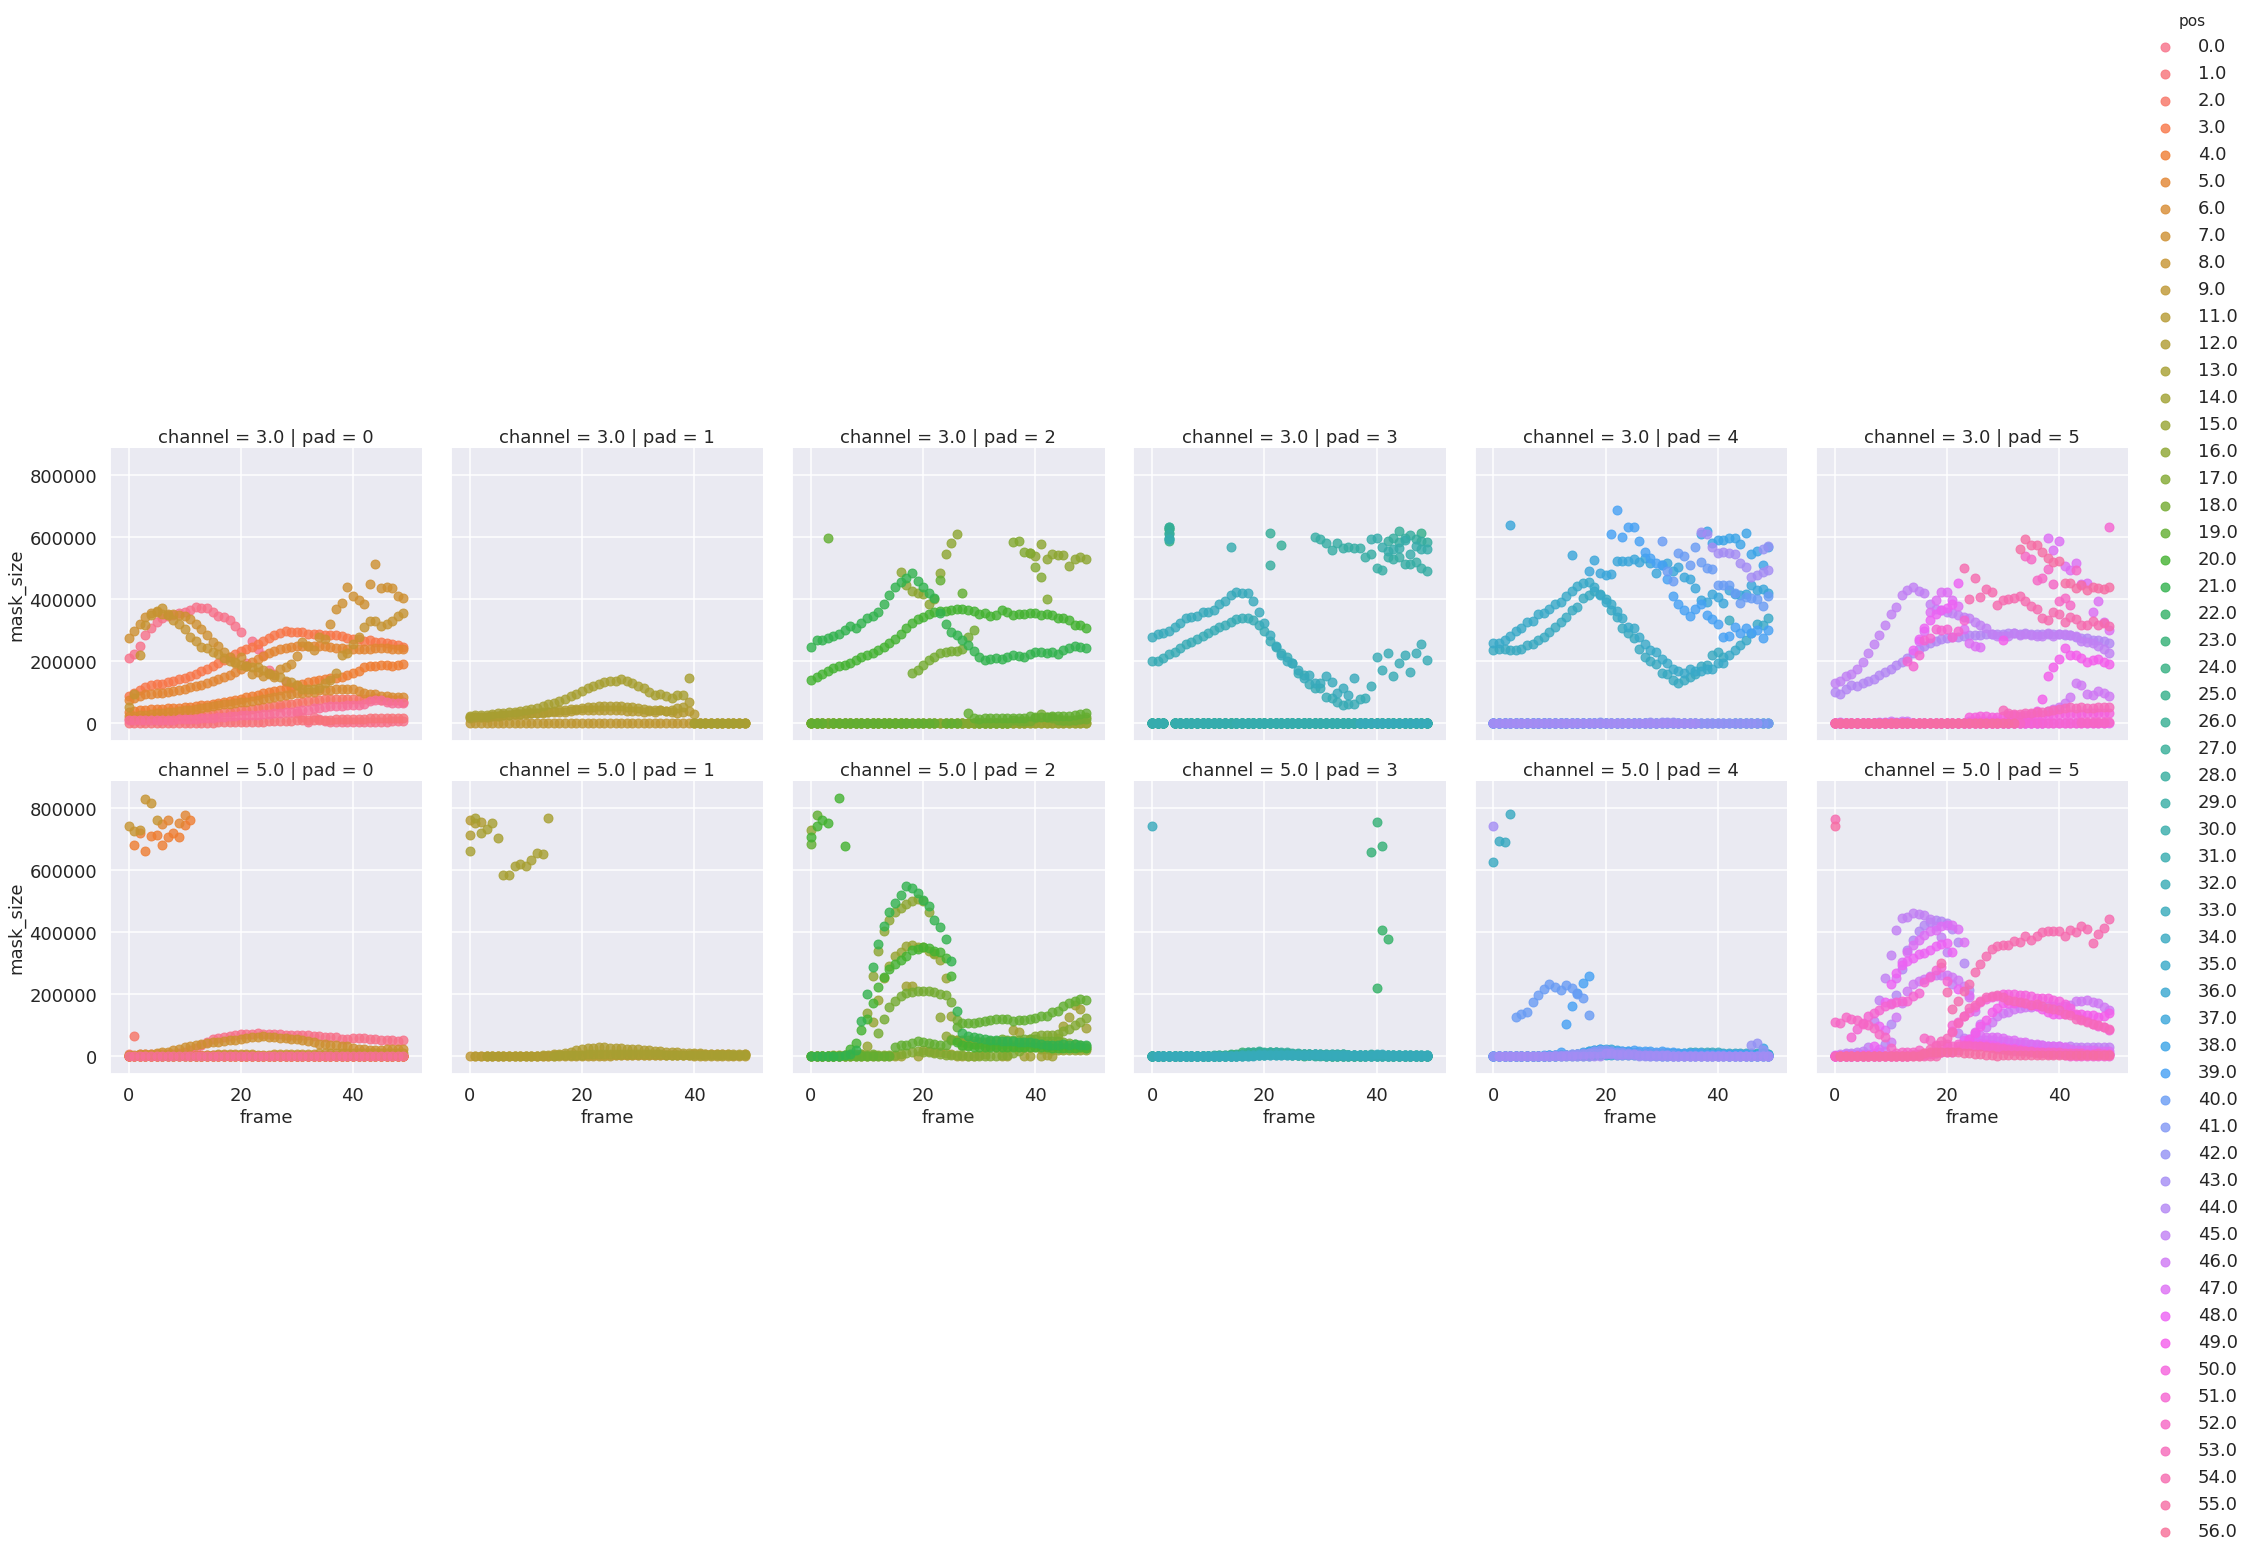

In [9]:
csv_out_tmp = "worker_outputs/mask_part{}.csv"
mask_csvs = [os.path.join('worker_outputs',xx) for xx in os.listdir('worker_outputs') if 'mask' in xx if 'csv' in xx]#[csv_out_tmp.format(xx) for xx in range(4)]
all_mask_dfs = pd.concat([pd.read_csv(xx, index_col=0) for xx in mask_csvs])

def pad_fn(pos):
    pad_limits = [9, 14, 22,34,44,56,57]    
    # using pad_limits, assign pad labels
    pad_ind = 0
    for lim in pad_limits:
        if pos >= lim:
            pad_ind += 1
        if pos == 56:
            pad_ind=0
    return pad_ind

all_mask_dfs = all_mask_dfs.assign(pad=np.array([pad_fn(xx) for xx in all_mask_dfs.pos.values]))
all_mask_dfs = all_mask_dfs.assign(strain=np.array([strain_fn(xx) for xx in all_mask_dfs.pos.values]))
masked_cfps = all_mask_dfs.loc[all_mask_dfs.pad >=0, :]
g = sns.lmplot(data=masked_cfps, x='frame', hue='pos', y='mask_size', row='channel', fit_reg=False, sharey=True, col='pad')

In [32]:
chan_inds = [3,5]
df_list = []
for chan_ind in chan_inds:
    plt.figure()
    sub_df = all_mask_dfs.loc[all_mask_dfs.channel == chan_ind, :]
    im_arr = sub_df.pivot(index='pos',columns='frame',values='mask_size').values[:,:30]
#     size_arr = sub_df.pivot(index='pos',columns='frame',values='mask_size').values[:,:25]
#     im_arr[size_arr < 3e4] = im_arr.min()
    n_pos, n_frames = im_arr.shape
#     thresh = skimage.filters.threshold_yen(im_arr[20:40,:])
    thresh = 5e4
    # cutoff
    im_arr[im_arr > 5.5e5] = im_arr.min()
    im_bool = 0.0+(im_arr > thresh)
    im_bool_dif = np.diff(im_bool,axis=1)
    im_bool_keeps = im_bool_dif > 0
    im_bool_throw = im_bool_dif < 1
    im_bool_keeps[:,0] = im_bool[:,0]>0
    frames_arr = np.concatenate([np.arange(n_frames-1).reshape((1,n_frames-1))]*n_pos,axis=0)
    print(frames_arr.shape)
    frames_arr[im_bool_throw] = n_frames
    pos_arr = np.concatenate([np.arange(n_pos).reshape((n_pos,1))]*(n_frames-1),axis=1)
    pos_arr[11:,:] = pos_arr[11:,:] + 1
    frames_arr[im_bool_throw] = 0
    pos_arr[im_bool_throw] = 0
    pos_vec = pos_arr
    flat_length = n_pos*(n_frames-1)
    flat_shape = (flat_length, 1)
    chan_arr = np.ones(flat_shape)*chan_ind
    flat_arr = np.concatenate((frames_arr.reshape(flat_shape), pos_arr.reshape(flat_shape), chan_arr),axis=1)
    cross_arr = flat_arr[im_bool_keeps.flatten(),:]
    cross_df = pd.DataFrame(np.zeros((cross_arr.shape[0],8)), 
                            columns=['frame','pos','channel','x','y','strain','pad','dist'])
    cross_df.loc[:,['frame','pos','channel']] = cross_arr
    for pos_ind in np.unique(cross_df.pos.values):
        sub_indx = cross_df.index[cross_df.pos==pos_ind]
        n_rows = np.sum(cross_df.pos==pos_ind)
        for col in ['strain', 'x', 'y','pad']:
            val = cor_pos_df.loc[cor_pos_df.pos==pos_ind, col].values[0]
            cross_df.loc[sub_indx,col]= np.int(val)
    
    df_list.append(cross_df)
    
all_cross_df = pd.concat(df_list, axis=0, ignore_index=True).sort_values(by=['x','y','frame','channel'])
pos_dist = cor_pos_df.loc[:,['pos','dist']].groupby('pos').agg(np.min)
for pos_ind in np.unique(all_cross_df.pos.values):
    sub_indx = all_cross_df.index[all_cross_df.pos==pos_ind]
#     print(all_cross_df.loc[sub_indx[:1],:])
#     pad, strain = all_cross_df.loc[sub_indx[0],['pad','strain']]
#     pad_strain_df = cor_pos_df.loc[(cor_pos_df.pad==pad)&(cor_pos_df.strain==strain),['x','y']]
#     pad_xy = pad_strain_df.iloc[0,:]
#     pos_xy = all_cross_df.loc[(all_cross_df.pos==pos_ind),['x','y']].iloc[0,:]
#     pos_dist = cor_pos_df.loc[cor-#np.sqrt(np.power(pad_xy-pos_xy,2).sum())
    all_cross_df.loc[sub_indx, 'dist'] = pos_dist.loc[pos_ind,'dist']
    

(56, 29)
(56, 29)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

/opt/anaconda/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


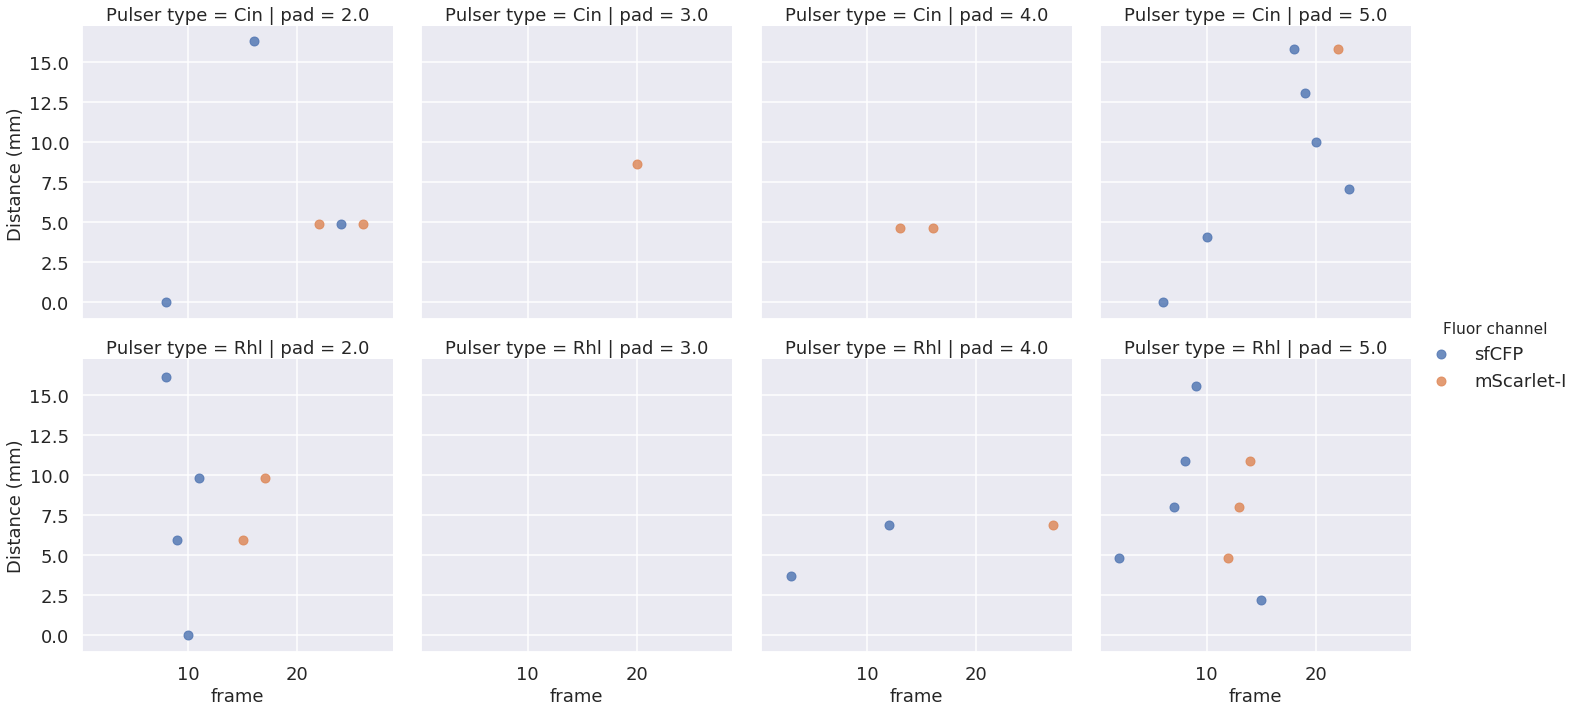

In [33]:
sub_df = all_cross_df.loc[(all_cross_df.frame < 40)&(all_cross_df.pad > 1),:]
sub_df.loc[sub_df.channel==3,'Fluor channel'] = 'mScarlet-I'
sub_df.loc[sub_df.channel==5,'Fluor channel'] = 'sfCFP'
sub_df.loc[sub_df.strain==0,'Pulser type'] = 'Cin'
sub_df.loc[sub_df.strain==1,'Pulser type'] = 'Rhl'
sub_df.loc[:,'Distance (mm)'] = sub_df['dist']/1e3
g = sns.lmplot(data=sub_df,x='frame', y='Distance (mm)',col='pad',row='Pulser type',hue='Fluor channel',
               fit_reg=False,sharex=True,sharey=True)
# g = sns.lmplot(data=cor_pos_df.loc[cor_pos_df.pad==4,:],x='pos', y='dist',col='pad',row='strain',#hue='channel',
#                fit_reg=False,sharex=True,sharey=True)

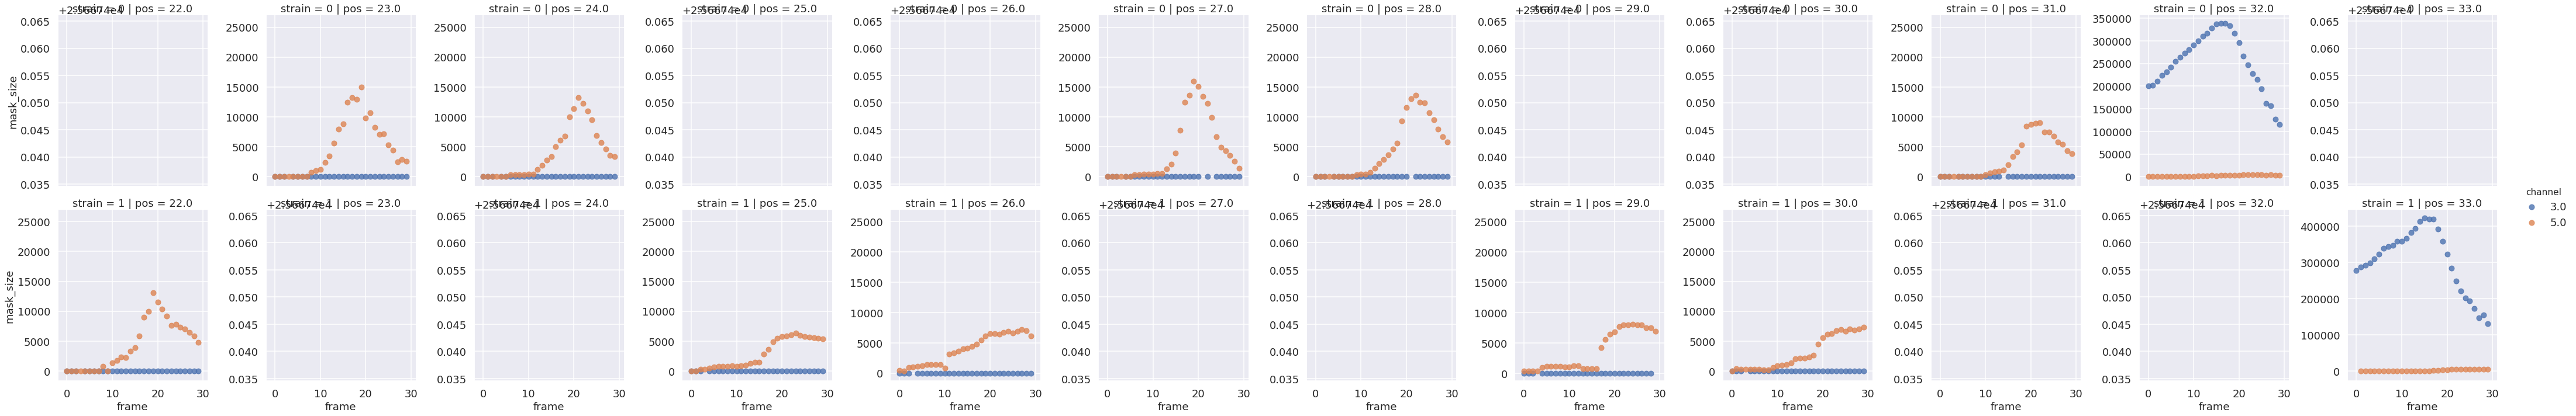

In [13]:
sub_df = all_mask_dfs.loc[(all_mask_dfs.frame<30)&(all_mask_dfs.pad==3)&(all_mask_dfs.mask_size < 5e5),:]
g = sns.lmplot(data=sub_df,x='frame', y='mask_size',row='strain',col='pos',hue='channel',
               fit_reg=False,sharex=True,sharey=False)


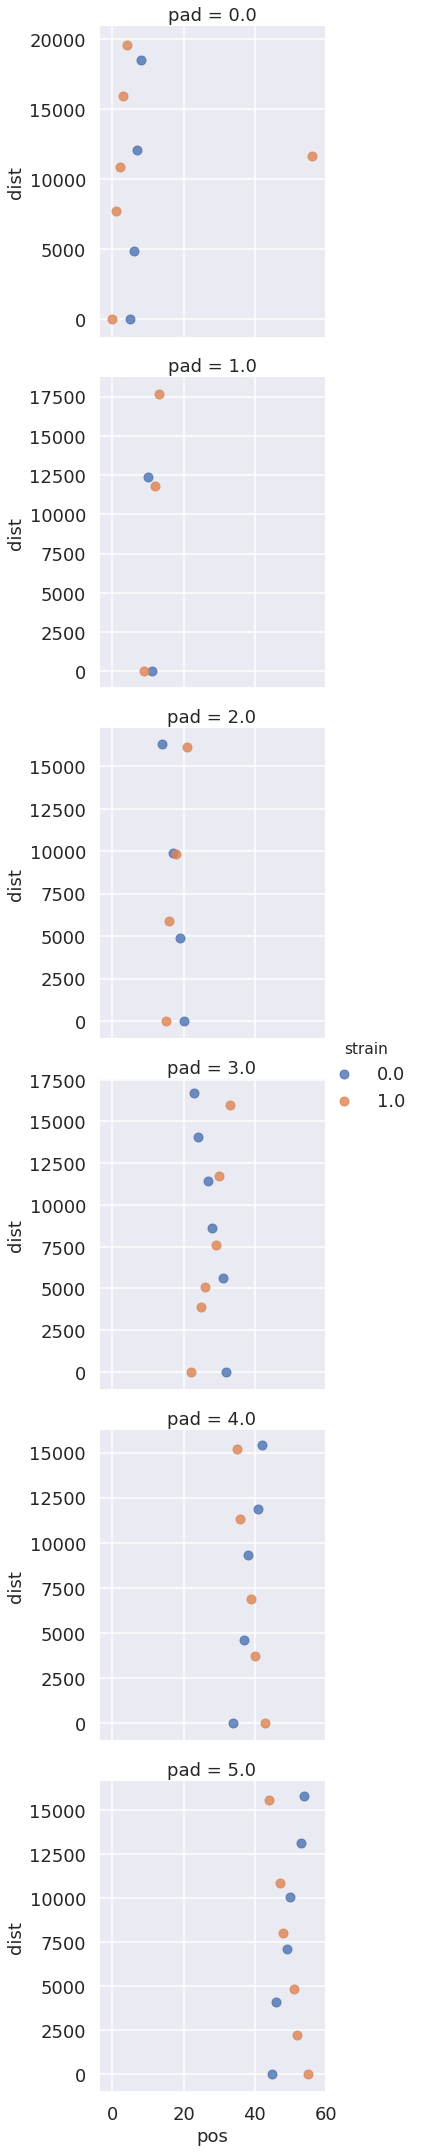

In [31]:
sub_df = cor_pos_df.loc[:,:]
g = sns.lmplot(data=sub_df,x='pos', y='dist',row='pad',hue='strain',#col='pos',hue='channel',
               fit_reg=False,sharex=True,sharey=False)


In [130]:
all_cross_df.loc[(all_cross_df.pos == 39),:]

,frame,pos,channel,x,y,strain,pad,dist
81,14.0,39.0,5.0,24158.0,-12036.0,1.0,4.0,6864.054389
82,17.0,39.0,5.0,24158.0,-12036.0,1.0,4.0,6864.054389


In [158]:
frames_arr = np.concatenate([np.arange(n_frames-1).reshape((1,n_frames-1))]*n_pos,axis=0)
frames_arr[im_bool[:,:-1]<1] = frames_arr.max()
frames_arr.min(axis=1)[38]

13

In [165]:
np.diff(im_bool+0.0,axis=1).min()

-1.0

In [24]:
sub_df

,frame,pos,channel,x,y,strain,pad,dist,Fluor channel,Pulser type,Distance (mm)
52,18.0,54.0,5.0,-10208.0,-10747.0,0.0,5.0,15812.553045,sfCFP,Cin,15.812553
29,22.0,54.0,3.0,-10208.0,-10747.0,0.0,5.0,15812.553045,mScarlet-I,Cin,15.812553
51,19.0,53.0,5.0,-7559.0,-10030.0,0.0,5.0,13088.459106,sfCFP,Cin,13.088459
50,15.0,52.0,5.0,-7208.0,-16846.0,1.0,5.0,2196.310397,sfCFP,Rhl,2.196310
48,2.0,51.0,5.0,-4568.0,-16436.0,1.0,5.0,4805.796876,sfCFP,Rhl,4.805797
28,12.0,51.0,3.0,-4568.0,-16436.0,1.0,5.0,4805.796876,mScarlet-I,Rhl,4.805797
47,20.0,50.0,5.0,-4547.0,-9558.0,0.0,5.0,10041.408113,sfCFP,Cin,10.041408
46,23.0,49.0,5.0,-1610.0,-9212.0,0.0,5.0,7083.897280,sfCFP,Cin,7.083897
45,7.0,48.0,5.0,-1362.0,-15981.0,1.0,5.0,8027.187518,sfCFP,Rhl,8.027188
27,13.0,48.0,3.0,-1362.0,-15981.0,1.0,5.0,8027.187518,mScarlet-I,Rhl,8.027188


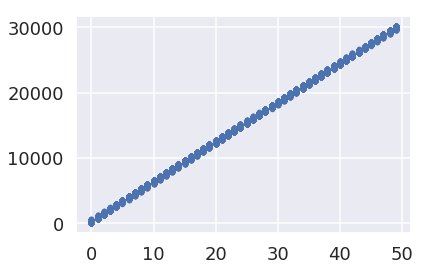

In [28]:
tmp_df = files_df.copy().sort_values(by='time')
plt.plot(tmp_df.frame, tmp_df.time, '.')

In [12]:
tmp = skimage.io.imread('190110_pad4.gif')

In [1]:
import skimage
import matplotlib.animation as anm
from IPython.display import HTML

# img = skimage.io.imread(f_names[2])
def write_movie(im_arr, title):
    
    n_frames, h, w, n_chan = im_arr.shape
    plt.close('all')

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    im = ax.imshow(im_arr[0,:,:,:], animated=True, interpolation='none')
#     cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    fig.tight_layout()
    
    def animate(i):
        # Plot 
        im.set_array(im_arr[i,:,:,:])
        
    # call the animator.  blit=True means only re-draw the parts that have changed.
#     writer = anm.HTMLWriter()
    anim = anm.FuncAnimation(fig, animate, interval=100, frames=n_frames)

    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())
    

# with skimage.external.tifffile.TiffFile('180320_fullmovie_masktry.tif') as img:
#     im_all = img.asarray()
anim_list = []
for fn in ['190110_pad5.gif','190110_pad4.gif','../../190108/190108/microscope-movie-analysis/pad5.gif']:
    tmp = skimage.io.imread(fn)
    anim_list.append(write_movie(tmp))

for fn in ['190110_pad5_again.gif','190110_pad4_again.gif','190108_pad5_again.gif']:
    anim.save(fn, dpi=80, fps=15, writer='pillow')


AttributeError: module 'skimage' has no attribute 'io'

In [15]:
tmp.shape

(50, 576, 576, 3)

In [16]:
anm.writers.avail

{'pillow': matplotlib.animation.PillowWriter,
 'html': matplotlib.animation.HTMLWriter}

In [17]:
anm.PillowWriter?